In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
!ls *.csv

credits_clean.csv
keywords_clean.csv
links_clean.csv
metadata_clean.csv


# Linear regression

In [84]:
meta = pd.read_csv('metadata_clean.csv')

In [85]:
meta.head()

,release_date,adult,genres,id,original_language,overview,popularity,production_countries,runtime,spoken_languages,status,title,video,vote_average,vote_count
0,1878-06-14,False,"[{'id': 99, 'name': 'Documentary'}]",194079.0,en,Sallie Gardner at a Gallop was one of the earl...,0.327841,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Sallie Gardner at a Gallop,False,6.2,25.0
1,1883-11-19,False,"[{'id': 99, 'name': 'Documentary'}]",426903.0,en,Individual photographs of the running of a buf...,0.229221,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Buffalo Running,False,5.4,7.0
2,1890-03-09,False,[],386743.0,en,Shot of the flight of a fly.,0.071756,[],1.0,[],Released,Mosquinha,False,6.5,2.0
3,1890-11-21,False,"[{'id': 35, 'name': 'Comedy'}]",32571.0,en,Experimental film made to test the original cy...,1.163672,"[{'iso_3166_1': 'US', 'name': 'United States o...",1.0,[],Released,"Monkeyshines, No. 1",False,4.3,15.0
4,1891-01-01,False,"[{'id': 99, 'name': 'Documentary'}]",336380.0,fr,This early cinematic instance of a close-up—or...,0.212894,"[{'iso_3166_1': 'FR', 'name': 'France'}]",1.0,"[{'iso_639_1': 'xx', 'name': 'No Language'}]",Released,Je Vous Aime,False,3.3,3.0


In [89]:
meta.release_date = pd.to_datetime(meta.release_date, format='%Y-%m-%d')

Text(0.5, 0, 'year')

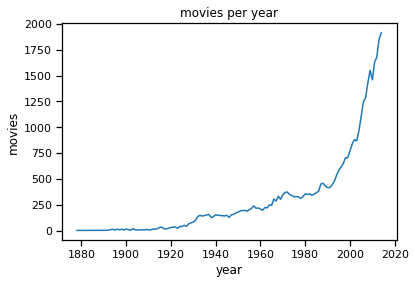

In [460]:
data = meta.release_date.dt.year.value_counts().sort_index()
X = np.array(data.index)[:-5].reshape(-1, 1)
y = data.values[:-5]
plt.plot(X, y)
plt.title('movies per year')
plt.ylabel('movies')
plt.xlabel('year')

**I use sqrt transformation of y value to use linear regression with second degree polynomilas**

In [421]:
# transforming the y value, using sqrt

y_tr = np.sqrt(y)
X_train = X[:]
y_train = y_tr[:]
X_test = X[:]
y_test = y_tr[:]

In [422]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor

In [423]:
linreg = LinearRegression()
neighbor = KNeighborsRegressor(n_neighbors = 10)

In [445]:
poly = PolynomialFeatures(degree = 2)
higher_x = poly.fit_transform(X_train)
higher_test = poly.transform(X)
linreg.fit(higher_x, y_train)
linreg_pred = linreg.predict(higher_test)
print("the value of R^2 for the linear regression: {}".format(linreg.score(higher_test, y_tr)))

the value of R^2 for the linear regression: 0.9406259651814423


In [439]:
neighbor.fit(X_train, y_train)
neighbor_pred = neighbor.predict(X)

**A comparison between nearest neighbors regression and linear regression**

Text(0.5, 0, 'year')

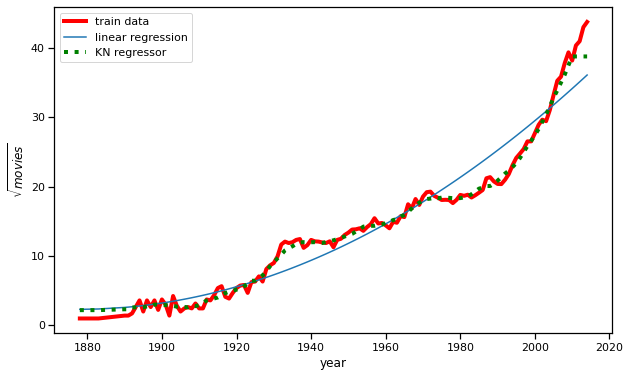

In [457]:
sns.set_context('notebook')
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, linewidth=4, color='red', label = 'train data')
plt.plot(X, linreg_pred, label = 'linear regression')
plt.plot(X, neighbor_pred, label = 'KN regressor', color='green', linestyle='dotted', linewidth=4)
plt.legend()
plt.ylabel("$\sqrt{movies}$")
plt.xlabel('year')

Text(0.5, 0, 'x')

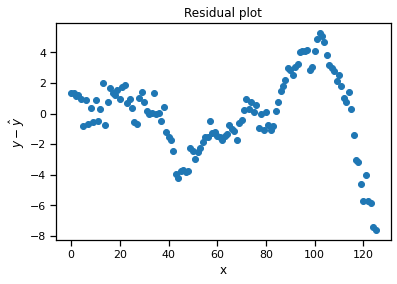

In [458]:
# plotting the residual plot
plt.plot(linreg_pred - y_tr, linestyle='None', marker='o')
plt.title('Residual plot')
plt.ylabel('$y - \hat{y}$')
plt.xlabel('x')

# Cluster analysis

## Full data

In [56]:
from scipy.sparse import csr_matrix

file=pd.read_csv(r'the-movies-dataset\ratings.csv')
file = file.drop('timestamp', axis=1)
user_u = list(sorted(file.userId.unique()))
item_u = list(sorted(file.movieId.unique()))

row = file.userId.astype('category', categories=user_u).cat.codes
col = file.movieId.astype('category', categories=item_u).cat.codes
data = file['rating'].tolist()
sparse_matrix = csr_matrix((data, (row, col)), shape=(len(user_u), len(item_u)))

C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  
C:\Users\amir\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if __name__ == '__main__':


**instead of making a pivot table out of the full data, which would take around 100 GB of memory, I used sparse matrix to save the pivot table into, also I used the Truncated SVD to decrease the dimensions of this data to 100 columns ( although just accounts for around 43% of the variance in the data. In the next section I will use a sample of this data and further analyse that**

In [59]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 100)
transformed = svd.fit_transform(sparse_matrix)

In [60]:
# the amount of variance in the data that is reflected in the dimension reduced version
svd.explained_variance_ratio_.cumsum()[-1]

0.42504683475254823

In [61]:
transformed.shape

(270896, 100)

In [62]:
from sklearn.cluster import KMeans

inertias = []
k_vals = range(2, 8)
for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(transformed)
    inertias.append(model.inertia_)

Text(0, 0.5, 'Inertia')

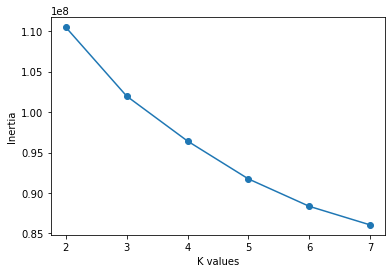

In [63]:
plt.plot(k_vals, inertias, marker = 'o')
plt.xlabel("K values")
plt.ylabel("Inertia")

**based on the values above, there is no clear "elbow" point to specify the value of cluster numbers from**

**Below, I use only 2 components to try to visualize the data**

In [77]:
svd2 = TruncatedSVD(n_components=2)
full_tr = svd2.fit_transform(sparse_matrix)

Text(0, 0.5, 'PC2')

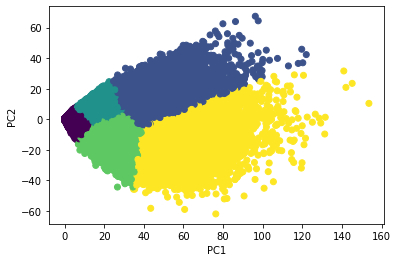

In [80]:
km = KMeans(n_clusters=5)
km.fit(full_tr)
plt.scatter(full_tr[:, 0], full_tr[:, 1], c = km.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')

In [83]:
print("2 prencipal components just account for {:.2f} % of variance in the original data".format(svd2.explained_variance_ratio_.cumsum()[1]))

2 prencipal components just account for 0.17 % of variance in the original data


## A sub sample of the full date

In [38]:
small = pd.read_csv(r'the-movies-dataset\ratings_small.csv')

In [39]:
small.shape

(100004, 4)

**A pivot table consisting of movies as the columns and users as the rows**

In [40]:
small = pd.pivot_table(small, values = 'rating', index = 'userId', columns='movieId', fill_value=0)

**decreasing the data dimensions using PCA, so that the reduced data accounts for more than 90% of the data**

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=300)
small_tr = pca.fit_transform(small)

In [42]:
pca.explained_variance_ratio_.cumsum()[-1]

0.9057863406468539

In [48]:
from sklearn.cluster import KMeans

k_vals = range(2, 11)
inertias = []
for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(small_tr)
    inertias.append(model.inertia_)

Text(0, 0.5, 'Inertia')

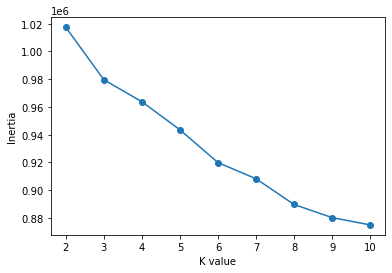

In [49]:
plt.plot(k_vals, inertias, marker = 'o')
plt.xlabel("K value")
plt.ylabel('Inertia')

**Based on the figure above, no clear "elbow" is to be observed**

**Yet using another measure to find the true cluster number, the silhouette score**

In [47]:
from sklearn.metrics import silhouette_score

for k in k_vals:
    model = KMeans(n_clusters = k)
    model.fit(small_tr)
    print("for {} clusters, silhouette score of {}".format(k, silhouette_score(small_tr, model.labels_)))

for 2 clusters, silhouette score of 0.4247891285365268
for 3 clusters, silhouette score of 0.27596894672692823
for 4 clusters, silhouette score of 0.38590542284395646
for 5 clusters, silhouette score of 0.2821015364660797
for 6 clusters, silhouette score of 0.16711029369755345
for 7 clusters, silhouette score of 0.023594743623528626
for 8 clusters, silhouette score of 0.0282762962885464
for 9 clusters, silhouette score of 0.028668171380175404


**based on the values of filhouette scores above, 2 to 5 clusters seem more promising...**

**Using t-SNE in order to visualize the data in 2 dimensions and hopefully see the cluster patterns**

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(learning_rate = 200)
tr = tsne.fit_transform(small)

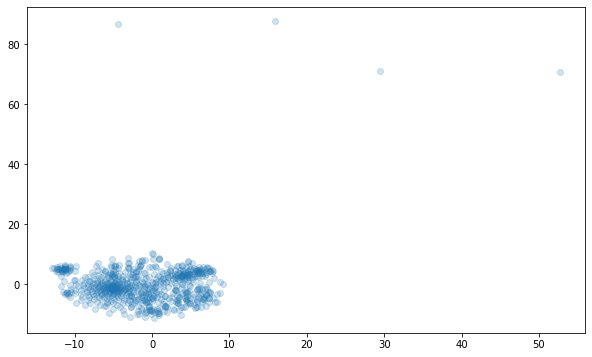

In [69]:
plt.figure(figsize=(10,6))
plt.scatter(tr[:, 0], tr[:, 1], alpha=.2)

**Visualization using PCA**

In [67]:
small_pca = PCA(n_components=2).fit_transform(small)

Text(0, 0.5, 'PC2')

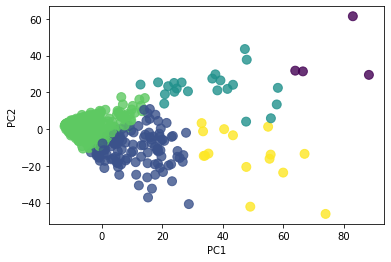

In [76]:
model = KMeans(n_clusters=5)
model.fit(small)
pred = model.labels_
plt.scatter(small_pca[:, 0], small_pca[:, 1], c = pred, alpha=.8, s=80)
plt.xlabel('PC1')
plt.ylabel('PC2')